# 1. Connecting to the Database

In order to work with a SQLite database from Python, we first have to connect to it. We can do that using the connect function, which returns a Connection object:

In [2]:
import sqlite3
conn = sqlite3.connect("flights.db")

No news means good news :) Once we have a Connection object, we can then create a Cursor object. Cursors allow us to execute SQL queries against a database:

In [3]:
cur = conn.cursor()

Once we have a Cursor object above, we can use it to execute a query against the database with the aptly named execute method :)

In [4]:
cur.execute ("select * from airlines limit 5;")
print (cur.fetchall())

[(0, '1', 'Private flight', '\\N', '-', None, None, None, 'Y'), (1, '2', '135 Airways', '\\N', None, 'GNL', 'GENERAL', 'United States', 'N'), (2, '3', '1Time Airline', '\\N', '1T', 'RNX', 'NEXTIME', 'South Africa', 'Y'), (3, '4', '2 Sqn No 1 Elementary Flying Training School', '\\N', None, 'WYT', None, 'United Kingdom', 'N'), (4, '5', '213 Flight Unit', '\\N', None, 'TFU', None, 'Russia', 'N')]


Uurgh, the results are formatted as a list of tuples. Each tuple corresponds to a row in the database that we accessed. Dealing with data this way looks fairly painful. We’d need to manually add column heads, and manually parse the data. Luckily, the pandas library has an easier way of doing it - let's try

[FYI] Wondering why we need to close connection and cursor objects that are open? It prevents the SQLite database from being locked. When a SQLite database is locked, we may be unable to update the database, and may get errors. 

In [5]:
cur.close()
conn.close()

# 2. Fun part: Mapping airports

1st, to create a plot that shows where all the airports in the world are - I will need to query latitudes and longitudes

In [6]:
import sqlite3
conn = sqlite3.connect("flights.db")
cur = conn.cursor()
coords = cur.execute("""SELECT CAST(longitude AS FLOAT), CAST(latitude AS FLOAT) FROM airports;""").fetchall()

2nd, time to call the libraries. 
The first one is matplotlib. 
The second one is basemap (this is what allows us to plot maps using Python). 

I did not have basemap installed so I went to my commandline and typed "conda install -c anaconda basemap" thanks to the resources on https://www.youtube.com/watch?v=Z_Kxg-EYvxM and https://anaconda.org/anaconda/basemap as I had Anaconda installed already 🙏🏼

In [7]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline

2.3 .3rd I need to setup the map, draw the continents and coastlines that will form the background of our map:

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.


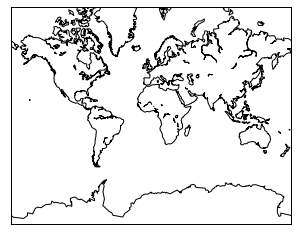

In [8]:
m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
m.drawcoastlines()
m.drawmapboundary()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.


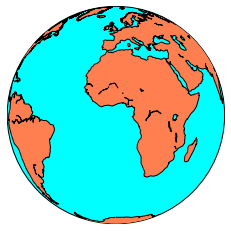

In [9]:
map = Basemap(projection='ortho', lat_0=0, lon_0=0)

#Fill the globe with a blue color 
map.drawmapboundary(fill_color='aqua')

#Fill the continents with the land color
map.fillcontinents(color='coral',lake_color='aqua')

map.drawcoastlines()

plt.show()


2.4 4th, I plot the coordinates of each airport onto the map. The plots are retrieved from a list of tuples from the SQLite database. The first element in each tuple is the longitude of the airport, and the second is the latitude. We need to convert the longitudes and latitudes into their own lists, and then plot them on the map:

RuntimeError: Can not put single artist in more than one figure

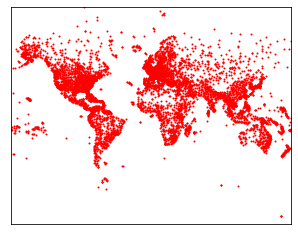

In [10]:
x, y = m([l[0] for l in coords], [l[1] for l in coords])
m.scatter(x,y,1, marker='o',color='red')

This data looks painful to work with 😿

# 3. The technical exploration and learning part

3.1 Can we use pandas read_sql_query function to read the results of a SQL query directly into a pandas DataFrame?  Let's try to execute the code above in this way. 
It will have several advantages over the query we did above by:

--> Not requiring us to create a Cursor object or call fetchall at the end.
--> Automatically reading in the names of the headers from the table.
--> Creating a DataFrame, so we can quickly explore the data.

In [11]:
import pandas as pd
import sqlite3
conn = sqlite3.connect("flights.db")

##Same as what we did at 1.3 but shorter and much more effective YAY!
df = pd.read_sql_query("SELECT * from airlines limit 5;", conn)
df

,index,id,name,alias,iata,icao,callsign,country,active
0,0,1,Private flight,\N,-,None,None,None,Y
1,1,2,135 Airways,\N,None,GNL,GENERAL,United States,N
2,2,3,1Time Airline,\N,1T,RNX,NEXTIME,South Africa,Y
3,3,4,2 Sqn No 1 Elementary Flying Training School,\N,None,WYT,None,United Kingdom,N
4,4,5,213 Flight Unit,\N,None,TFU,None,Russia,N


WOOOOOOOOOWWWWWWWWWWWWWW 👯‍♂️

In [12]:
##It is also easier to manipulate the Dataframe in this case. Example: 
df["country"]

0              None
1     United States
2      South Africa
3    United Kingdom
4            Russia
Name: country, dtype: object

Let's try this again 

In [13]:
#The below query will:

#Get the latitude and longitude for the source airport for each route.
#Get the latitude and longitude for the destination airport for each route.
#Convert all the coordinate values to floats.
#Read the results into a DataFrame, and store them to the variable routes

routes = pd.read_sql_query("""
SELECT
cast(sa.longitude as float) as source_lon,
cast(sa.latitude as float) as source_lat,
cast(da.longitude as float) as dest_lon,
cast(da.latitude as float) as dest_lat
FROM routes
INNER JOIN airports sa on sa.id = routes.source_id
INNER JOIN airports da on da.id = routes.dest_id;
""",
conn)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until


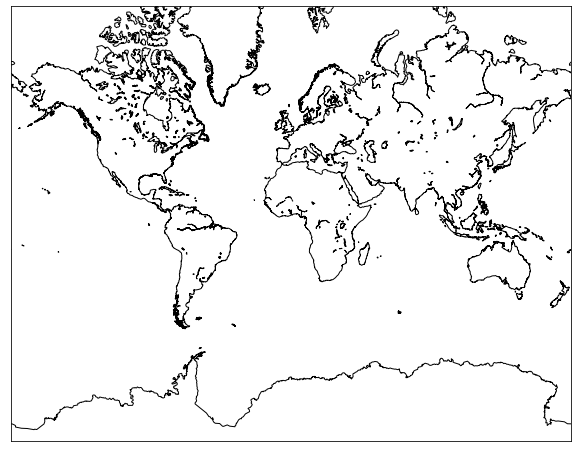

In [30]:
#After this we set up our map
plt.figure(figsize = (16,8))
m = Basemap(projection='merc', llcrnrlat=-80, urcrnrlat=80, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='l')
m.drawcoastlines()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


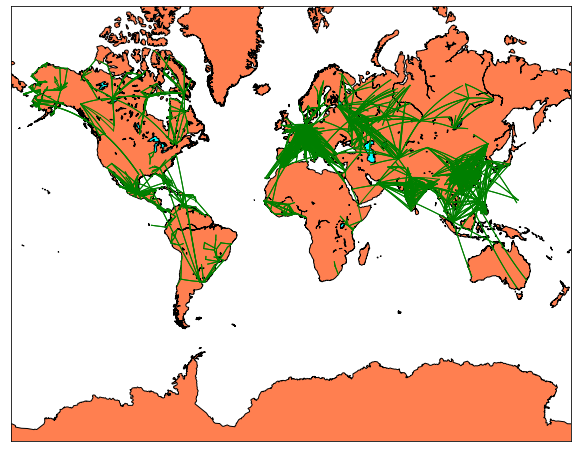

In [38]:
plt.figure(figsize = (16,8))
m = Basemap(projection='merc', llcrnrlat=-80, urcrnrlat=80, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='l')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
#Going through the first 3000 rows to draw them.
for name, row in routes[:3000].iterrows():
    if abs(row["source_lon"] - row["dest_lon"]) < 90:
        # Draw a great circle between source and dest airports.
        m.drawgreatcircle(row["source_lon"], row["source_lat"], row["dest_lon"], row["dest_lat"], linewidth=1, color='g')

Lesson: Pandas can help to turn the results of a SQL query into a DataFrame, instead of having us work with the raw results from sqlite3. 🛀🏼

# 4. Modifying database rows

4.1 INSERT is interesting with SQL Lite because UNLESS you commit to a TRANSACTION, SQLite will not commit to the database. Transactions allow you to run several queries, then finally alter the database with the results of all of them. This ensures that if one of the queries fails, the database isn’t partially updated.

Example where this could be handy is at the bank. 

Let’s say a bank customer, Zizi, wants to send $50 to Luisa. In order to make this work, the bank would need to:

- Create a row in charges that says $50 is being taken from Roberto’s account and sent to Luisa.
- Update Zizi’s row in the balances table and remove $50.
- Update Luisa’s row in the balances table and add $50.

These will require three separate SQL queries to update all of the tables. If a query fails, we’ll be stuck with bad data in our database. For example, if the first two queries work, then the third fails, Roberto will lose his money, but Luisa won’t get it. Transactions mean that the main database isn’t updated unless all the queries succeed. This prevents the system from getting into a bad state, where customers lose their money.

In [57]:
# We can commit the transaction, and add our new row to the airlines table, using the commit method:

cur = conn.cursor()
cur.execute("INSERT into airlines values (6061, 19846, 'Kenya Airways', '' , '','', '', '','')")
conn.commit()

In [58]:
#Test this to see if we have an extra row
new_row = pd.read_sql_query ("SELECT * FROM airlines WHERE id=19846", conn)

In [59]:
new_row

,index,id,name,alias,iata,icao,callsign,country,active
0,6061,19846,Kenya Airways,,,,,,


4.2 We can use the execute method to UPDATE the data in the rows. Example: 

In [63]:
cur = conn.cursor()
values = ('USA', 19846)
cur.execute("UPDATE airlines SET country=? WHERE id=?", values)
conn.commit()

In [64]:
pd.read_sql_query("select * from airlines where id=19846;", conn)

,index,id,name,alias,iata,icao,callsign,country,active
0,6061,19846,Kenya Airways,,,,,USA,


4.3 We can DELETE rows with the EXECUTE method

In [66]:
cur = conn.cursor()
values = (19846, )
cur.execute("DELETE from airlines WHERE id=?", values)
conn.commit()

In [67]:
pd.read_sql_query("select * from airlines where id=19846;", conn)

,index,id,name,alias,iata,icao,callsign,country,active


# 5. Lastly, dealing with tables

5.1 Let's make a table that represents each daily flight on a route, with the following columns:

id — integer
departure — date, when the flight left the airport
arrival — date, when the flight arrived at the destination
number — text, the flight number
route_id — integer, the id of the route the flight was flying

NOTICE the methods used for EXECUTION vs those used for QUERYING


In [68]:
cur = conn.cursor()
cur.execute("CREATE TABLE daily_flights (Id integer, Departure date, Arrival date, Number string, Route_id integer)")
conn.commit()

In [69]:
cur.execute("INSERT INTO daily_flights values (1, '2016-09-28 0:00', '2016-09-28 12:00', 'T1', 1)")
conn.commit()

In [70]:
pd.read_sql_query("select * from daily_flights;", conn)

,Id,Departure,Arrival,Number,Route_id
0,1,2016-09-28 0:00,2016-09-28 12:00,T1,1
